Context leak detected, msgtracer returned -1


Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x36af65070_48&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x36b9fe510_49&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x390410d40_50&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x34fedcce0_51&reconnect=auto" class="pyvist…

Cluster 0: Detected Shape - Cylinder-like (elongated along Z)
Cluster 1: Detected Shape - Cylinder-like (elongated along Z)
Cluster 2: Detected Shape - Cylinder-like (elongated along Z)
Cluster 3: Detected Shape - Cylinder-like (elongated along Z)
Grasp Plan 1: Centroid at [ 1.08875677e-02 -1.40581724e-05  6.96515766e-06]
Grasp Plan 2: Centroid at [-0.13310048 -0.01764257  0.01608137]
Grasp Plan 3: Centroid at [-0.13549603  0.01225103 -0.01137257]
Grasp Plan 4: Centroid at [ 5.91160672e-02 -2.03819637e-05  9.17874230e-06]
For n_clusters = 2, silhouette score is 0.605
For n_clusters = 3, silhouette score is 0.597
For n_clusters = 4, silhouette score is 0.582
For n_clusters = 5, silhouette score is 0.339


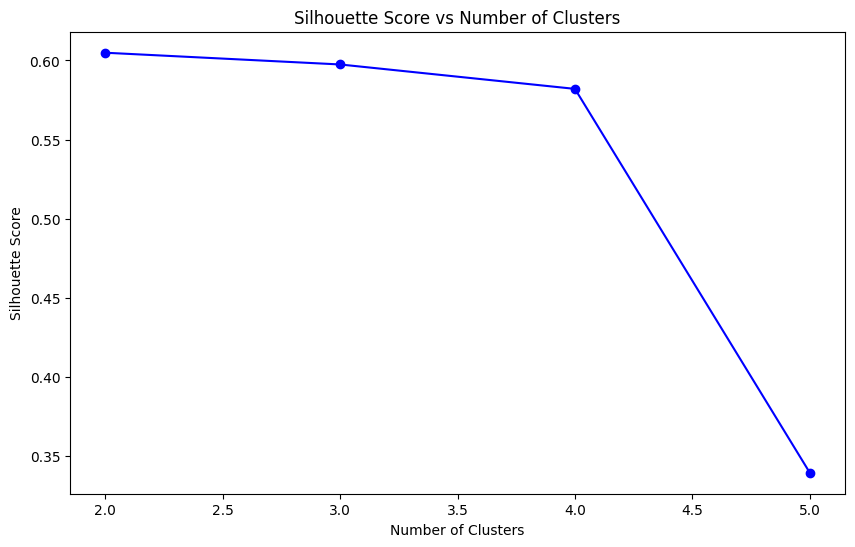

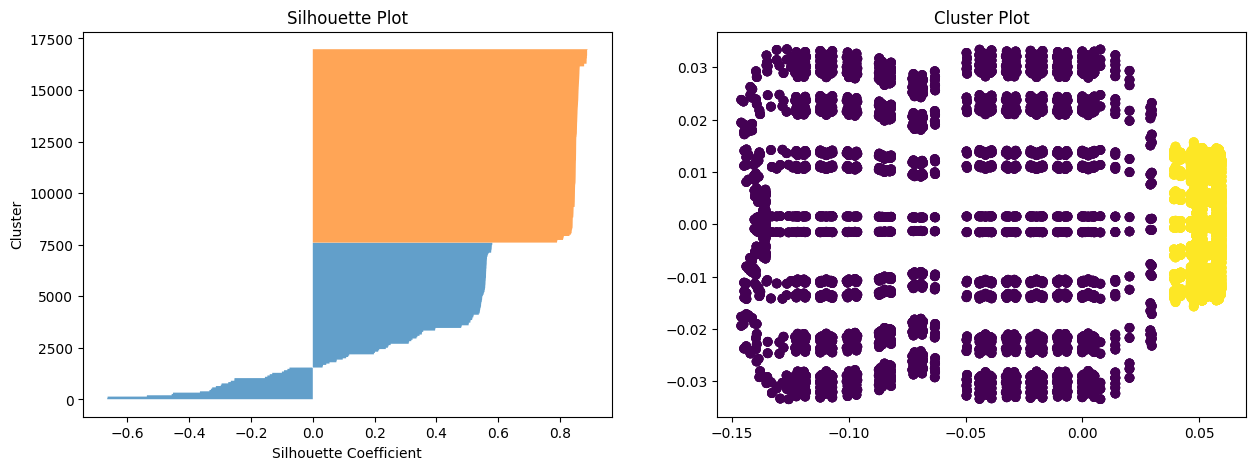

In [14]:
import numpy as np
import pyvista as pv
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial import ConvexHull
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from time import time

def load_and_display_obj(file_path):
    mesh = pv.read(file_path)
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, color='white', show_edges=True)
    plotter.show()
    return mesh

def reduce_dimensions(mesh, n_components=3):
    points = mesh.points
    pca = PCA(n_components=n_components)
    reduced_points = pca.fit_transform(points)
    reduced_cloud = pv.PolyData(reduced_points)
    plotter = pv.Plotter()
    plotter.add_mesh(reduced_cloud, render_points_as_spheres=True, point_size=5)
    plotter.show()
    return reduced_points, pca

def filter_convex_hull(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_cloud = pv.PolyData(hull_points)
    plotter = pv.Plotter()
    plotter.add_mesh(hull_cloud, color='blue', render_points_as_spheres=True, point_size=5)
    plotter.show()
    return hull_points

def fit_mixture_of_gaussians(points, n_components=4):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(points)
    labels = gmm.predict(points)
    clustered_cloud = pv.PolyData(points)
    clustered_cloud["Cluster"] = labels
    plotter = pv.Plotter()
    plotter.add_mesh(clustered_cloud, render_points_as_spheres=True, point_size=5)
    plotter.show()
    return labels, gmm

def detect_and_print_primitives(points, labels):
    unique_labels = np.unique(labels)
    detected_shapes = []
    for label in unique_labels:
        cluster_points = points[labels == label]
        bounds = np.ptp(cluster_points, axis=0)
        dimensions = bounds / np.max(bounds)
        if np.allclose(dimensions, [1, 1, 1], atol=0.2):
            shape = "Sphere or Cube"
        elif dimensions[0] > dimensions[1] and dimensions[0] > dimensions[2]:
            shape = "Cylinder-like (elongated along X)"
        elif dimensions[1] > dimensions[0] and dimensions[1] > dimensions[2]:
            shape = "Cylinder-like (elongated along Y)"
        elif dimensions[2] > dimensions[0] and dimensions[2] > dimensions[1]:
            shape = "Cylinder-like (elongated along Z)"
        else:
            shape = "Irregular/Unknown"
        detected_shapes.append(shape)
        print(f"Cluster {label}: Detected Shape - {shape}")
    return detected_shapes

def generate_grasp_plan(points, labels):
    cluster_centroids = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = points[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        centroid = np.array(centroid, dtype=np.float64)
        cluster_centroids.append(centroid)
    return cluster_centroids

def analyze_clusters(points, n_clusters_range=range(2, 6)):
    silhouette_scores = []
    for n_clusters in n_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(points)
        score = silhouette_score(points, labels)
        silhouette_scores.append(score)
        print(f"For n_clusters = {n_clusters}, silhouette score is {score:.3f}")
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.show()
    best_n = n_clusters_range[np.argmax(silhouette_scores)]
    visualize_silhouette(points, best_n)

def visualize_silhouette(points, n_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(points)
    silhouette_vals = silhouette_samples(points, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_vals.sort()
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_vals,
                          alpha=0.7)
        y_lower = y_upper + 10
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster")
    ax2.scatter(points[:, 0], points[:, 1], c=cluster_labels, cmap='viridis')
    ax2.set_title("Cluster Plot")
    plt.show()

def main():
    obj_file_path = "../obj/bottle.obj"
    mesh = load_and_display_obj(obj_file_path)
    reduced_points, _ = reduce_dimensions(mesh)
    hull_points = filter_convex_hull(reduced_points)
    labels, gmm = fit_mixture_of_gaussians(hull_points, n_components=4)
    detected_shapes = detect_and_print_primitives(hull_points, labels)
    centroids = generate_grasp_plan(hull_points, labels)
    for idx, centroid in enumerate(centroids):
        print(f"Grasp Plan {idx + 1}: Centroid at {centroid}")
    analyze_clusters(reduced_points)

if __name__ == "__main__":
    main()

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x3f356b4d0_72&reconnect=auto" class="pyvist…

Context leak detected, msgtracer returned -1


Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x3f356bc50_73&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x3c7796330_74&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x390451130_75&reconnect=auto" class="pyvist…

Cluster 0: Detected Shape - Cylinder-like (elongated along X)
Cluster 1: Detected Shape - Cylinder-like (elongated along Y)
Cluster 2: Detected Shape - Cylinder-like (elongated along Z)
Cluster 3: Detected Shape - Cylinder-like (elongated along Z)
Grasp Plan 1: Centroid at [-0.07035011 -0.29833169 -0.00245693]
Grasp Plan 2: Centroid at [ 0.17982079 -0.25411492 -0.00195232]
Grasp Plan 3: Centroid at [0.24815771 0.16583119 0.00140718]
Grasp Plan 4: Centroid at [-0.27652541  0.09764322  0.00063443]
For n_clusters = 2, silhouette score is 0.419
For n_clusters = 3, silhouette score is 0.372
For n_clusters = 4, silhouette score is 0.324
For n_clusters = 5, silhouette score is 0.369


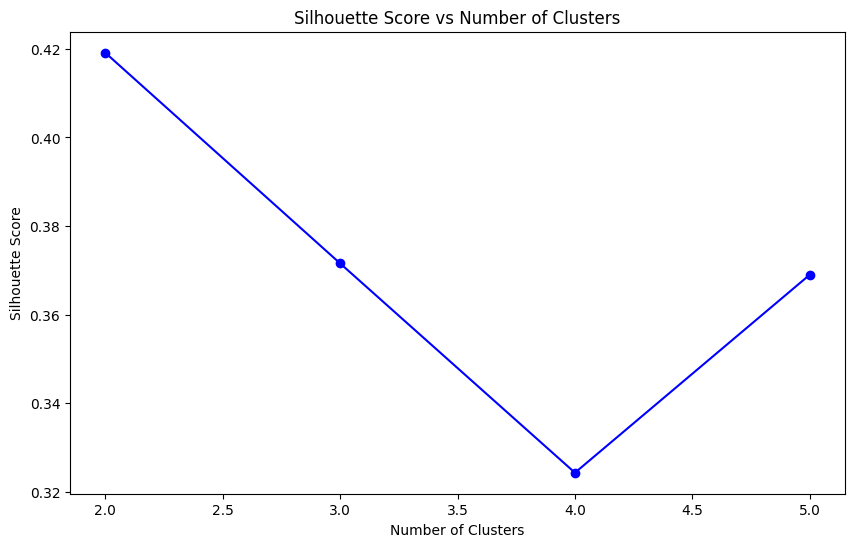

Best number of clusters based on silhouette score: 2


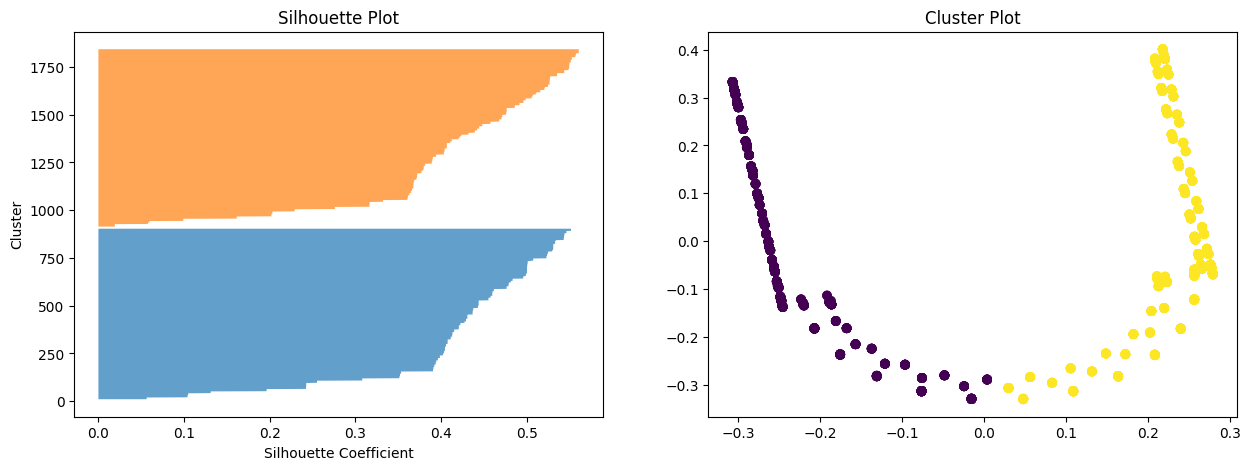

In [20]:
import numpy as np
import pyvista as pv
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from time import time

def load_and_display_obj(file_path):
    mesh = pv.read(file_path)
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, color='white', show_edges=True)
    plotter.show()
    return mesh

def reduce_dimensions(mesh, n_components=3):
    points = mesh.points
    pca = PCA(n_components=n_components)
    reduced_points = pca.fit_transform(points)
    reduced_cloud = pv.PolyData(reduced_points)
    plotter = pv.Plotter()
    plotter.add_mesh(reduced_cloud, render_points_as_spheres=True, point_size=5)
    plotter.show()
    return reduced_points, pca

def filter_convex_hull(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_cloud = pv.PolyData(hull_points)
    plotter = pv.Plotter()
    plotter.add_mesh(hull_cloud, color='blue', render_points_as_spheres=True, point_size=5)
    plotter.show()
    return hull_points

def fit_mixture_of_gaussians(points, n_components=4):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(points)
    labels = gmm.predict(points)
    clustered_cloud = pv.PolyData(points)
    clustered_cloud["Cluster"] = labels
    plotter = pv.Plotter()
    plotter.add_mesh(clustered_cloud, render_points_as_spheres=True, point_size=5)
    plotter.show()
    return labels, gmm

def detect_and_print_primitives(points, labels):
    unique_labels = np.unique(labels)
    detected_shapes = []
    for label in unique_labels:
        cluster_points = points[labels == label]
        bounds = np.ptp(cluster_points, axis=0)
        dimensions = bounds / np.max(bounds)
        if np.allclose(dimensions, [1, 1, 1], atol=0.2):
            shape = "Sphere or Cube"
        elif dimensions[0] > dimensions[1] and dimensions[0] > dimensions[2]:
            shape = "Cylinder-like (elongated along X)"
        elif dimensions[1] > dimensions[0] and dimensions[1] > dimensions[2]:
            shape = "Cylinder-like (elongated along Y)"
        elif dimensions[2] > dimensions[0] and dimensions[2] > dimensions[1]:
            shape = "Cylinder-like (elongated along Z)"
        else:
            shape = "Irregular/Unknown"
        detected_shapes.append(shape)
        print(f"Cluster {label}: Detected Shape - {shape}")
    return detected_shapes

def generate_grasp_plan(points, labels):
    cluster_centroids = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = points[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        centroid = np.array(centroid, dtype=np.float64)
        cluster_centroids.append(centroid)
    return cluster_centroids

def analyze_clusters(points, n_clusters_range=range(2, 6)):
    silhouette_scores = []
    for n_clusters in n_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(points)
        score = silhouette_score(points, labels)
        silhouette_scores.append(score)
        print(f"For n_clusters = {n_clusters}, silhouette score is {score:.3f}")
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.show()
    best_n = n_clusters_range[np.argmax(silhouette_scores)]
    print(f"Best number of clusters based on silhouette score: {best_n}")
    visualize_silhouette(points, best_n)

def visualize_silhouette(points, n_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(points)
    silhouette_vals = silhouette_samples(points, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_vals.sort()
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, alpha=0.7)
        y_lower = y_upper + 10
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster")
    ax2.scatter(points[:, 0], points[:, 1], c=cluster_labels, cmap='viridis')
    ax2.set_title("Cluster Plot")
    plt.show()

def main():
    obj_file_path = "../obj/cup.obj"
    mesh = load_and_display_obj(obj_file_path)
    reduced_points, _ = reduce_dimensions(mesh)
    hull_points = filter_convex_hull(reduced_points)
    labels, gmm = fit_mixture_of_gaussians(hull_points, n_components=4)
    detected_shapes = detect_and_print_primitives(hull_points, labels)
    centroids = generate_grasp_plan(hull_points, labels)
    for idx, centroid in enumerate(centroids):
        print(f"Grasp Plan {idx + 1}: Centroid at {centroid}")
    analyze_clusters(reduced_points)

if __name__ == "__main__":
    main()

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x323f8f5c0_56&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x337fc7e90_57&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x37ce6b1d0_58&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x337ffda60_59&reconnect=auto" class="pyvist…

Cluster 0: Detected Shape - Cylinder-like (elongated along Z)
Cluster 1: Detected Shape - Cylinder-like (elongated along Z)
Cluster 2: Detected Shape - Cylinder-like (elongated along Z)
Cluster 3: Detected Shape - Cylinder-like (elongated along Z)
Grasp Plan 1: Centroid at [0.25385236 0.12572917 0.04761816]
Grasp Plan 2: Centroid at [-0.42673077  0.14696336  0.01328166]
Grasp Plan 3: Centroid at [ 0.12131841 -0.04201496 -0.04200226]
Grasp Plan 4: Centroid at [-0.08094122 -0.23375066  0.03615692]
For n_clusters = 2, silhouette score is 0.539
For n_clusters = 3, silhouette score is 0.515
For n_clusters = 4, silhouette score is 0.473
For n_clusters = 5, silhouette score is 0.343


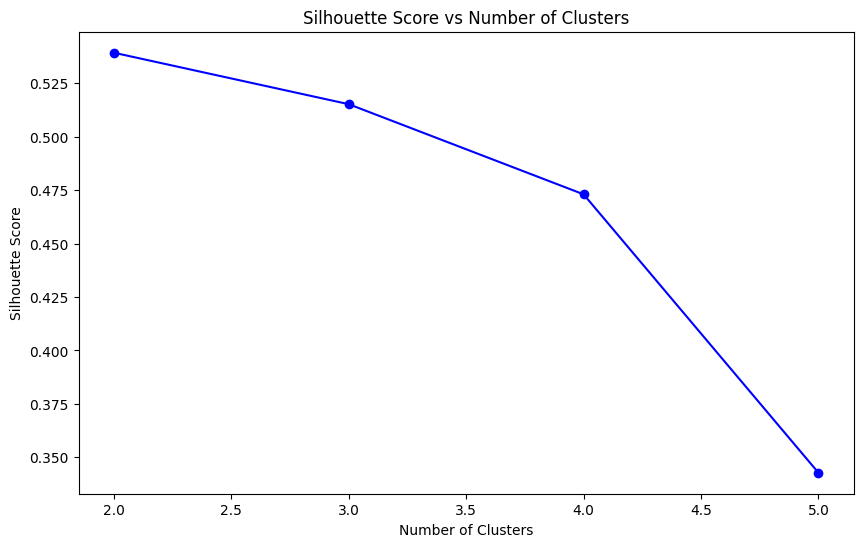

Best number of clusters based on silhouette score: 2


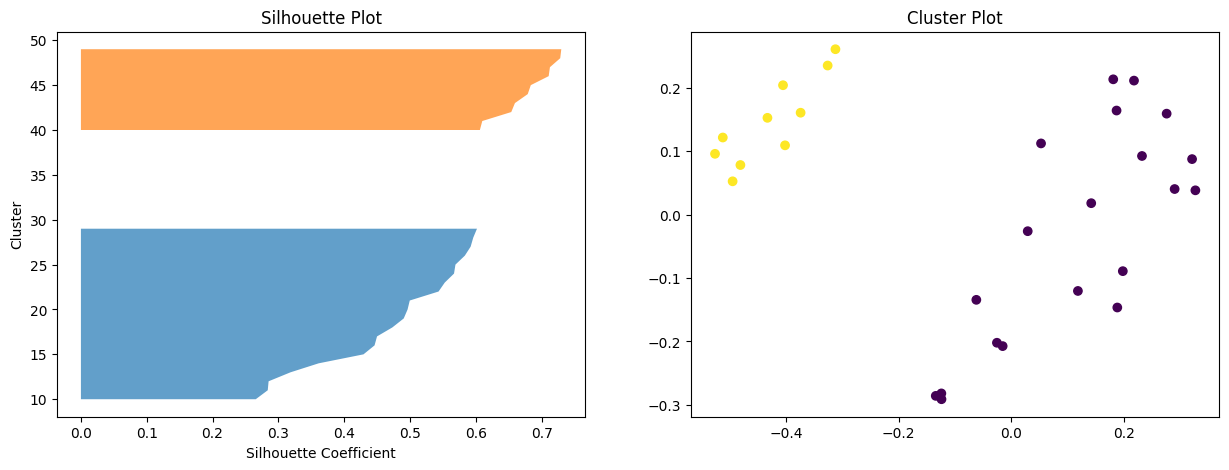

In [16]:
import numpy as np
import pyvista as pv
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial import ConvexHull

def load_and_display_obj(file_path):
    mesh = pv.read(file_path)
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, color='white', show_edges=True)
    plotter.show()
    return mesh

def reduce_dimensions(mesh, n_components=3):
    points = mesh.points
    pca = PCA(n_components=n_components)
    reduced_points = pca.fit_transform(points)
    reduced_cloud = pv.PolyData(reduced_points)
    plotter = pv.Plotter()
    plotter.add_mesh(reduced_cloud, render_points_as_spheres=True, point_size=5)
    plotter.show()
    return reduced_points, pca

def filter_convex_hull(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_cloud = pv.PolyData(hull_points)
    plotter = pv.Plotter()
    plotter.add_mesh(hull_cloud, color='blue', render_points_as_spheres=True, point_size=5)
    plotter.show()
    return hull_points

def fit_mixture_of_gaussians(points, n_components=4):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(points)
    labels = gmm.predict(points)
    clustered_cloud = pv.PolyData(points)
    clustered_cloud["Cluster"] = labels
    plotter = pv.Plotter()
    plotter.add_mesh(clustered_cloud, render_points_as_spheres=True, point_size=5)
    plotter.show()
    return labels, gmm

def detect_and_print_primitives(points, labels):
    unique_labels = np.unique(labels)
    detected_shapes = []
    for label in unique_labels:
        cluster_points = points[labels == label]
        bounds = np.ptp(cluster_points, axis=0)
        dimensions = bounds / np.max(bounds)
        if np.allclose(dimensions, [1, 1, 1], atol=0.2):
            shape = "Sphere or Cube"
        elif dimensions[0] > dimensions[1] and dimensions[0] > dimensions[2]:
            shape = "Cylinder-like (elongated along X)"
        elif dimensions[1] > dimensions[0] and dimensions[1] > dimensions[2]:
            shape = "Cylinder-like (elongated along Y)"
        elif dimensions[2] > dimensions[0] and dimensions[2] > dimensions[1]:
            shape = "Cylinder-like (elongated along Z)"
        else:
            shape = "Irregular/Unknown"
        detected_shapes.append(shape)
        print(f"Cluster {label}: Detected Shape - {shape}")
    return detected_shapes

def generate_grasp_plan(points, labels):
    cluster_centroids = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = points[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        centroid = np.array(centroid, dtype=np.float64)
        cluster_centroids.append(centroid)
    return cluster_centroids

def analyze_clusters(points, n_clusters_range=range(2, 6)):
    silhouette_scores = []
    for n_clusters in n_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(points)
        score = silhouette_score(points, labels)
        silhouette_scores.append(score)
        print(f"For n_clusters = {n_clusters}, silhouette score is {score:.3f}")
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.show()
    best_n = n_clusters_range[np.argmax(silhouette_scores)]
    print(f"Best number of clusters based on silhouette score: {best_n}")
    visualize_silhouette(points, best_n)

def visualize_silhouette(points, n_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(points)
    silhouette_vals = silhouette_samples(points, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_vals.sort()
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, alpha=0.7)
        y_lower = y_upper + 10
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster")
    ax2.scatter(points[:, 0], points[:, 1], c=cluster_labels, cmap='viridis')
    ax2.set_title("Cluster Plot")
    plt.show()

def main():
    obj_file_path = "../obj/lamp.obj"
    mesh = load_and_display_obj(obj_file_path)
    reduced_points, _ = reduce_dimensions(mesh)
    hull_points = filter_convex_hull(reduced_points)
    labels, gmm = fit_mixture_of_gaussians(hull_points, n_components=4)
    detected_shapes = detect_and_print_primitives(hull_points, labels)
    centroids = generate_grasp_plan(hull_points, labels)
    for idx, centroid in enumerate(centroids):
        print(f"Grasp Plan {idx + 1}: Centroid at {centroid}")
    analyze_clusters(reduced_points)

if __name__ == "__main__":
    main()

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x3484dd430_80&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x3484dd070_81&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x34fecfb00_82&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x3484dff80_83&reconnect=auto" class="pyvist…

Cluster 0: Detected Shape - Cylinder-like (elongated along Y)
Cluster 1: Detected Shape - Cylinder-like (elongated along Y)
Cluster 2: Detected Shape - Cylinder-like (elongated along Z)
Cluster 3: Detected Shape - Irregular/Unknown
Grasp Plan 1: Centroid at [-1.20710728 -0.70710642 -0.20710567]
Grasp Plan 2: Centroid at [0.20710725 0.70710856 1.20710587]
Grasp Plan 3: Centroid at [ 0.90236853 -0.47140566 -0.4309639 ]
Grasp Plan 4: Centroid at [-0.7071055   1.41421278 -0.70710877]
For n_clusters = 2, silhouette score is 0.255
For n_clusters = 3, silhouette score is 0.370
For n_clusters = 4, silhouette score is 0.536
For n_clusters = 5, silhouette score is 0.628


/var/folders/pm/_y3ccgc55js8fzl2fwr1p2nr0000gn/T/ipykernel_82032/2421334139.py:50: RuntimeWarning: invalid value encountered in divide
  dimensions = bounds / np.max(bounds)


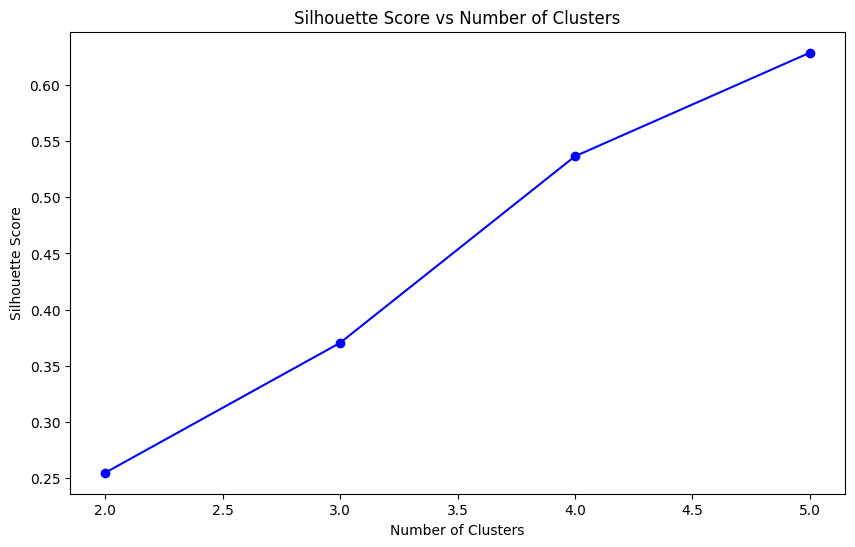

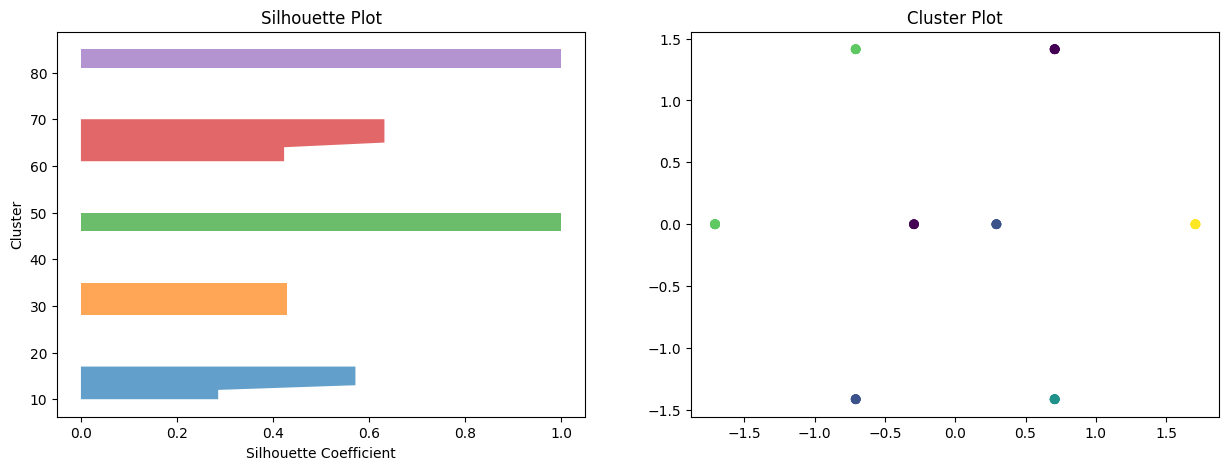

In [22]:
import numpy as np
import pyvista as pv
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial import ConvexHull

def load_and_display_obj(file_path):
    mesh = pv.read(file_path)
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, color='white', show_edges=True)
    plotter.show()
    return mesh

def reduce_dimensions(mesh, n_components=3):
    points = mesh.points
    pca = PCA(n_components=n_components)
    reduced_points = pca.fit_transform(points)
    reduced_cloud = pv.PolyData(reduced_points)
    plotter = pv.Plotter()
    plotter.add_mesh(reduced_cloud, render_points_as_spheres=True, point_size=5)
    plotter.show()
    return reduced_points, pca

def filter_convex_hull(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_cloud = pv.PolyData(hull_points)
    plotter = pv.Plotter()
    plotter.add_mesh(hull_cloud, color='blue', render_points_as_spheres=True, point_size=5)
    plotter.show()
    return hull_points

def fit_mixture_of_gaussians(points, n_components=4):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(points)
    labels = gmm.predict(points)
    clustered_cloud = pv.PolyData(points)
    clustered_cloud["Cluster"] = labels
    plotter = pv.Plotter()
    plotter.add_mesh(clustered_cloud, render_points_as_spheres=True, point_size=5)
    plotter.show()
    return labels, gmm

def detect_and_print_primitives(points, labels):
    unique_labels = np.unique(labels)
    detected_shapes = []
    for label in unique_labels:
        cluster_points = points[labels == label]
        bounds = np.ptp(cluster_points, axis=0)
        dimensions = bounds / np.max(bounds)
        if np.allclose(dimensions, [19, 19, 19], atol=0.02):
            shape = "Sphere or Cube"
        elif dimensions[0] > dimensions[1] and dimensions[0] > dimensions[2]:
            shape = "Cylinder-like (elongated along X)"
        elif dimensions[1] > dimensions[0] and dimensions[1] > dimensions[2]:
            shape = "Cylinder-like (elongated along Y)"
        elif dimensions[2] > dimensions[0] and dimensions[2] > dimensions[1]:
            shape = "Cylinder-like (elongated along Z)"
        else:
            shape = "Irregular/Unknown"
        detected_shapes.append(shape)
        print(f"Cluster {label}: Detected Shape - {shape}")
    return detected_shapes

def generate_grasp_plan(points, labels):
    cluster_centroids = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = points[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        centroid = np.array(centroid, dtype=np.float64)
        cluster_centroids.append(centroid)
    return cluster_centroids
def analyze_clusters(points, n_clusters_range=range(2, 6)):
    silhouette_scores = []
    for n_clusters in n_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(points)
        score = silhouette_score(points, labels)
        silhouette_scores.append(score)
        print(f"For n_clusters = {n_clusters}, silhouette score is {score:.3f}")
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.show()
    best_n = n_clusters_range[np.argmax(silhouette_scores)]
    visualize_silhouette(points, best_n)

def visualize_silhouette(points, n_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(points)
    silhouette_vals = silhouette_samples(points, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_vals.sort()
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_vals,
                          alpha=0.7)
        y_lower = y_upper + 10
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster")
    ax2.scatter(points[:, 0], points[:, 1], c=cluster_labels, cmap='viridis')
    ax2.set_title("Cluster Plot")
    plt.show()

def main():
    obj_file_path = "../obj/cube.obj"
    mesh = load_and_display_obj(obj_file_path)
    reduced_points, _ = reduce_dimensions(mesh)
    hull_points = filter_convex_hull(reduced_points)
    labels, gmm = fit_mixture_of_gaussians(hull_points, n_components=4)
    detected_shapes = detect_and_print_primitives(hull_points, labels)
    centroids = generate_grasp_plan(hull_points, labels)
    for idx, centroid in enumerate(centroids):
        print(f"Grasp Plan {idx + 1}: Centroid at {centroid}")
    analyze_clusters(reduced_points)

if __name__ == "__main__":
    main()

2025-01-22 15:30:28.493 (1433.303s) [          2A18D0]       vtkOBJReader.cxx:215   WARN| vtkOBJReader (0x4107b0450): unexpected data at end of line in OBJ file L.3


Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x34e52ff20_84&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x36b990f50_85&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x33ba7c6e0_86&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:50153/index.html?ui=P_0x34e52ef00_87&reconnect=auto" class="pyvist…

Cluster 0: Detected Shape - Cylinder-like (elongated along X)
Cluster 1: Detected Shape - Cylinder-like (elongated along Z)
Cluster 2: Detected Shape - Cylinder-like (elongated along Y)
Cluster 3: Detected Shape - Sphere or Cube
Grasp Plan 1: Centroid at [ 0.08519437 -0.6971799  -0.16843825]
Grasp Plan 2: Centroid at [-0.70062766  0.17371759 -0.04030424]
Grasp Plan 3: Centroid at [0.2378867  0.1164757  0.67224966]
Grasp Plan 4: Centroid at [ 0.37602128  0.40705684 -0.46329642]
For n_clusters = 2, silhouette score is 0.254
For n_clusters = 3, silhouette score is 0.266
For n_clusters = 4, silhouette score is 0.290
For n_clusters = 5, silhouette score is 0.280


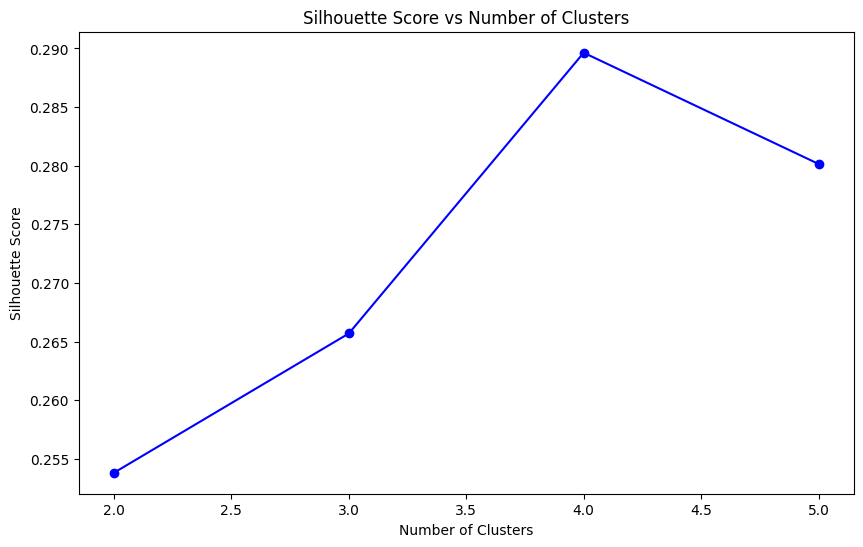

Best number of clusters based on silhouette score: 4


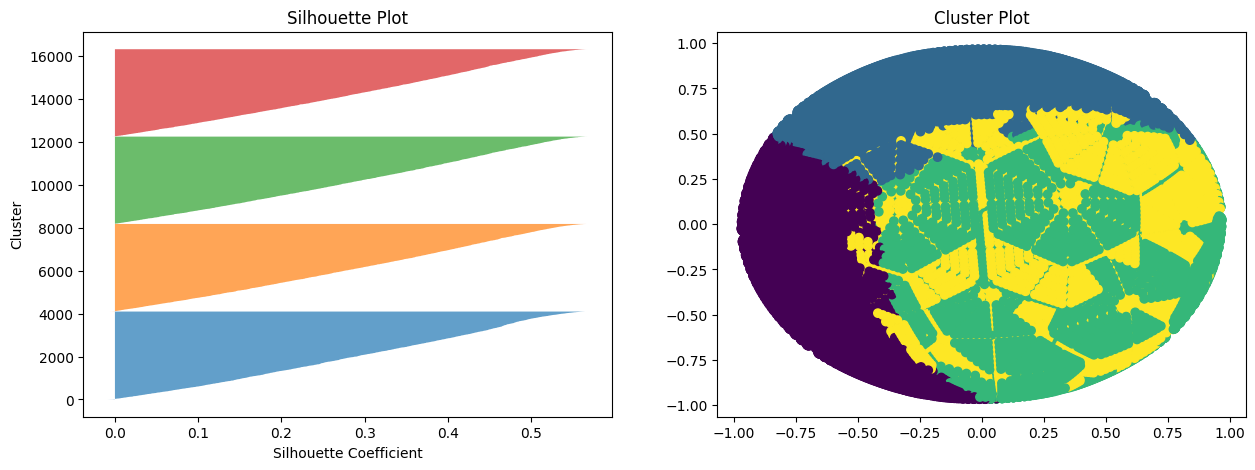

In [23]:
import numpy as np
import pyvista as pv
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial import ConvexHull

def load_and_display_obj(file_path):
    mesh = pv.read(file_path)
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, color='white', show_edges=True)
    plotter.show()
    return mesh

def reduce_dimensions(mesh, n_components=3):
    points = mesh.points
    pca = PCA(n_components=n_components)
    reduced_points = pca.fit_transform(points)
    reduced_cloud = pv.PolyData(reduced_points)
    plotter = pv.Plotter()
    plotter.add_mesh(reduced_cloud, render_points_as_spheres=True, point_size=5)
    plotter.show()
    return reduced_points, pca

def filter_convex_hull(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_cloud = pv.PolyData(hull_points)
    plotter = pv.Plotter()
    plotter.add_mesh(hull_cloud, color='blue', render_points_as_spheres=True, point_size=5)
    plotter.show()
    return hull_points

def fit_mixture_of_gaussians(points, n_components=2):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(points)
    labels = gmm.predict(points)
    clustered_cloud = pv.PolyData(points)
    clustered_cloud["Cluster"] = labels
    plotter = pv.Plotter()
    plotter.add_mesh(clustered_cloud, render_points_as_spheres=True, point_size=5)
    plotter.show()
    return labels, gmm

def detect_and_print_primitives(points, labels):
    unique_labels = np.unique(labels)
    detected_shapes = []
    for label in unique_labels:
        cluster_points = points[labels == label]
        bounds = np.ptp(cluster_points, axis=0)
        dimensions = bounds / np.max(bounds)
        if np.allclose(dimensions, [1, 1, 1], atol=0.2):
            shape = "Sphere or Cube"
        elif dimensions[0] > dimensions[1] and dimensions[0] > dimensions[2]:
            shape = "Cylinder-like (elongated along X)"
        elif dimensions[1] > dimensions[0] and dimensions[1] > dimensions[2]:
            shape = "Cylinder-like (elongated along Y)"
        elif dimensions[2] > dimensions[0] and dimensions[2] > dimensions[1]:
            shape = "Cylinder-like (elongated along Z)"
        else:
            shape = "Irregular/Unknown"
        detected_shapes.append(shape)
        print(f"Cluster {label}: Detected Shape - {shape}")
    return detected_shapes

def generate_grasp_plan(points, labels):
    cluster_centroids = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = points[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        centroid = np.array(centroid, dtype=np.float64)
        cluster_centroids.append(centroid)
    return cluster_centroids

def analyze_clusters(points, n_clusters_range=range(2, 6)):
    silhouette_scores = []
    for n_clusters in n_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(points)
        score = silhouette_score(points, labels)
        silhouette_scores.append(score)
        print(f"For n_clusters = {n_clusters}, silhouette score is {score:.3f}")
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.show()
    best_n = n_clusters_range[np.argmax(silhouette_scores)]
    print(f"Best number of clusters based on silhouette score: {best_n}")
    visualize_silhouette(points, best_n)

def visualize_silhouette(points, n_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(points)
    silhouette_vals = silhouette_samples(points, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_vals.sort()
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, alpha=0.7)
        y_lower = y_upper + 10
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster")
    ax2.scatter(points[:, 0], points[:, 1], c=cluster_labels, cmap='viridis')
    ax2.set_title("Cluster Plot")
    plt.show()

def main():
    obj_file_path = "../obj/Ball.obj"
    mesh = load_and_display_obj(obj_file_path)
    reduced_points, _ = reduce_dimensions(mesh)
    hull_points = filter_convex_hull(reduced_points)
    labels, gmm = fit_mixture_of_gaussians(hull_points, n_components=4)
    detected_shapes = detect_and_print_primitives(hull_points, labels)
    centroids = generate_grasp_plan(hull_points, labels)
    for idx, centroid in enumerate(centroids):
        print(f"Grasp Plan {idx + 1}: Centroid at {centroid}")
    analyze_clusters(reduced_points)

if __name__ == "__main__":
    main()